In [1]:
# NOTE: !!! THIS CELL SHOULD BE RUN FIRST !!!

# Jupyter notebooks have a bad interaction with virtual environments: 
# they perceive the PYTHONPATH as the folder the venv was activated
# instead of whatever the current directory of the .ipynb file is
# so we need to incorporate this hack

import sys

filepath = "/Users/colinyao/Desktop/Code/FINM/FixedIncome_37400"
# change this path to whatever the path to this file is on your computer
sys.path.append(filepath)

import os
os.chdir(filepath)

In [22]:
import pandas as pd
from sklearn.linear_model import LinearRegression as LR
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import scipy

In [3]:
# reading in data

selected_quotes = pd.read_excel("./data/treasury_quotes_2025-11-28.xlsx", sheet_name='selected quotes', index_col=0)
quotes = pd.read_excel("./data/treasury_quotes_2025-11-28.xlsx", sheet_name='quotes', index_col=0)


## 1.1

In [81]:
selected_quotes
payoff_dict = {}

for ix, row in selected_quotes.iterrows():
    payoffs = {}
    curr_date = row['issue date']
    if curr_date.month == 5:
        curr_date = curr_date.replace(month=6, day=1)
    elif curr_date.month == 11:
        curr_date = curr_date.replace(month=12, day=1)
    while curr_date < row['maturity date']:
        payoffs[curr_date] = row['cpn rate']
        curr_date += pd.DateOffset(months=6)
    payoffs[curr_date] = 100 + row['cpn rate']
    payoff_dict[ix] = payoffs
cashflow_matrix = pd.DataFrame(payoff_dict).sort_index().transpose().fillna(0)

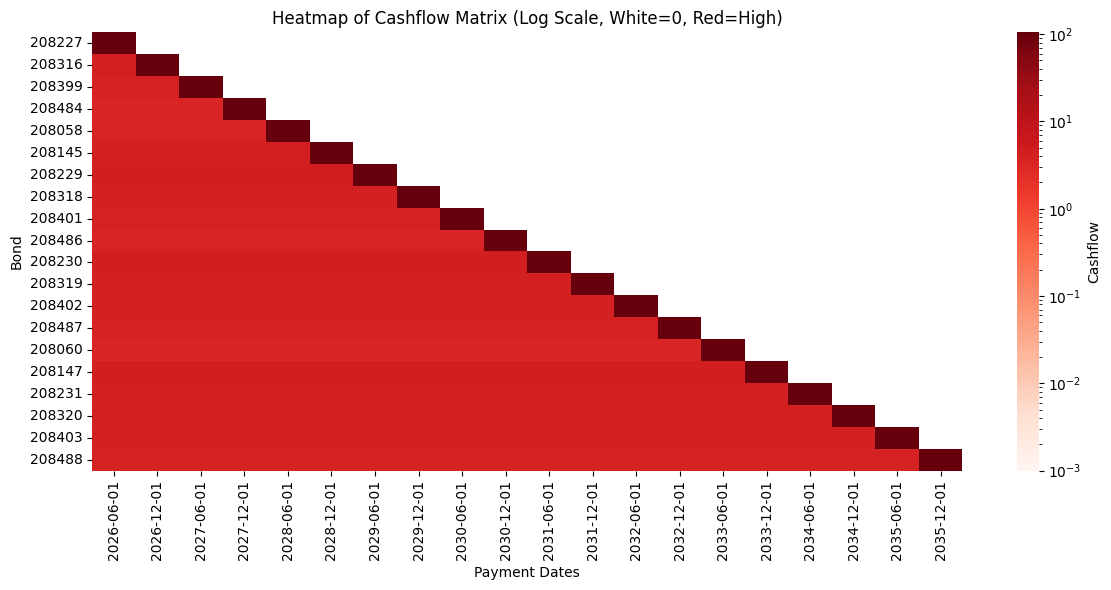

In [93]:
# display
# cutoff all cashflow from before first maturation date
first_maturation_date = cashflow_matrix.columns.min()
cashflow_matrix = cashflow_matrix.loc[:, cashflow_matrix.columns > first_maturation_date]
# Change columns in cashflow_matrix to just dates (remove time for easier visualization)
# cashflow_matrix.columns = cashflow_matrix.columns.date


plt.figure(figsize=(12, 6))
sns.heatmap(
    cashflow_matrix, 
    cmap="Reds",            # 0=white, high=red
    norm=plt.matplotlib.colors.LogNorm(vmin=1e-3, vmax=cashflow_matrix.values.max()),  # log scale, avoid log(0)
    cbar_kws={'label': 'Cashflow'}
)
plt.title("Heatmap of Cashflow Matrix (Log Scale, White=0, Red=High)")
plt.xlabel("Payment Dates")
plt.ylabel("Bond")
plt.tight_layout()
plt.show()

## 1.2

In [94]:
instrument_prices = selected_quotes['price']
discount_regression = LR(fit_intercept=False)
discount_regression.fit(cashflow_matrix, instrument_prices)

def describe_lr(lr, indep_data, dep_data, annual_factor=12):
    alpha = lr.intercept_ * annual_factor
    betas = lr.coef_
    rsquare = lr.score(indep_data, dep_data)

    stats_list = [alpha] + list(betas) + [rsquare]
    stats_names = ['alpha (annualized)'] + ['beta ' + str(n) for n in range(len(betas))] + ['r squared']

    return pd.Series(stats_list, index=stats_names)

spot_discount_factors = dict(zip(cashflow_matrix.columns, discount_regression.coef_))
spot_discount_factors = {k: v for k, v in spot_discount_factors.items() if k.year >= 2026}

## 1.3

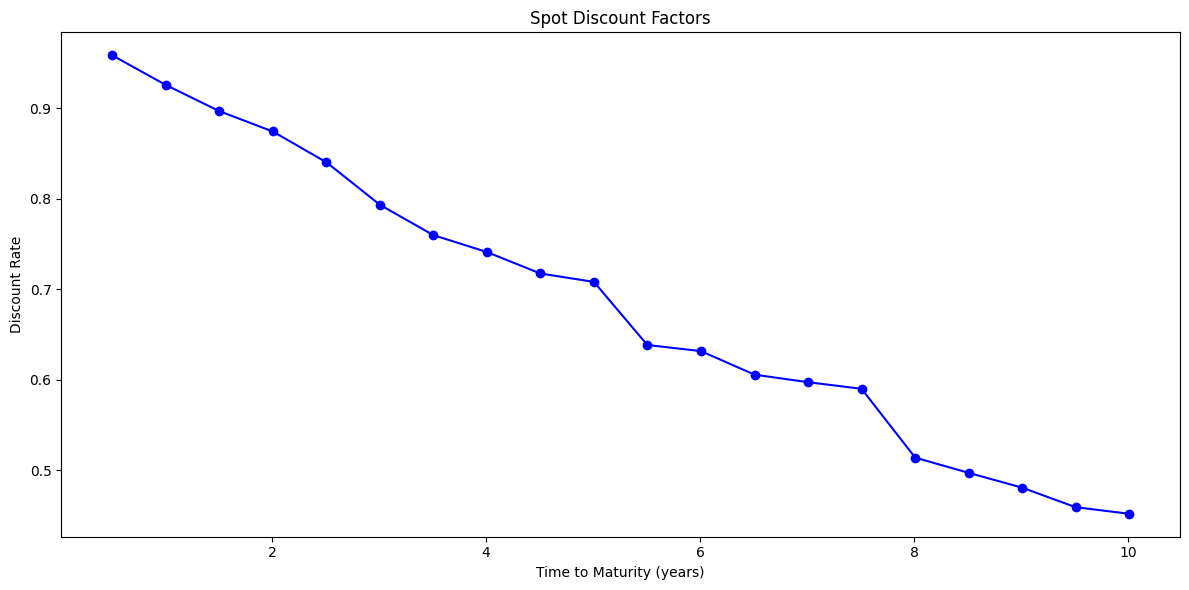

In [95]:
quote_date_ts = selected_quotes['quote date'].iloc[0]
quote_date = dt.date(quote_date_ts.year, quote_date_ts.month, quote_date_ts.day)

plt.figure(figsize=(12, 6))
plt.plot([(k - quote_date).days / 365.25 for k in spot_discount_factors.keys()], spot_discount_factors.values(), marker='o', linestyle='-', color='b')
plt.title("Spot Discount Factors")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Discount Rate")
plt.tight_layout()
plt.show()

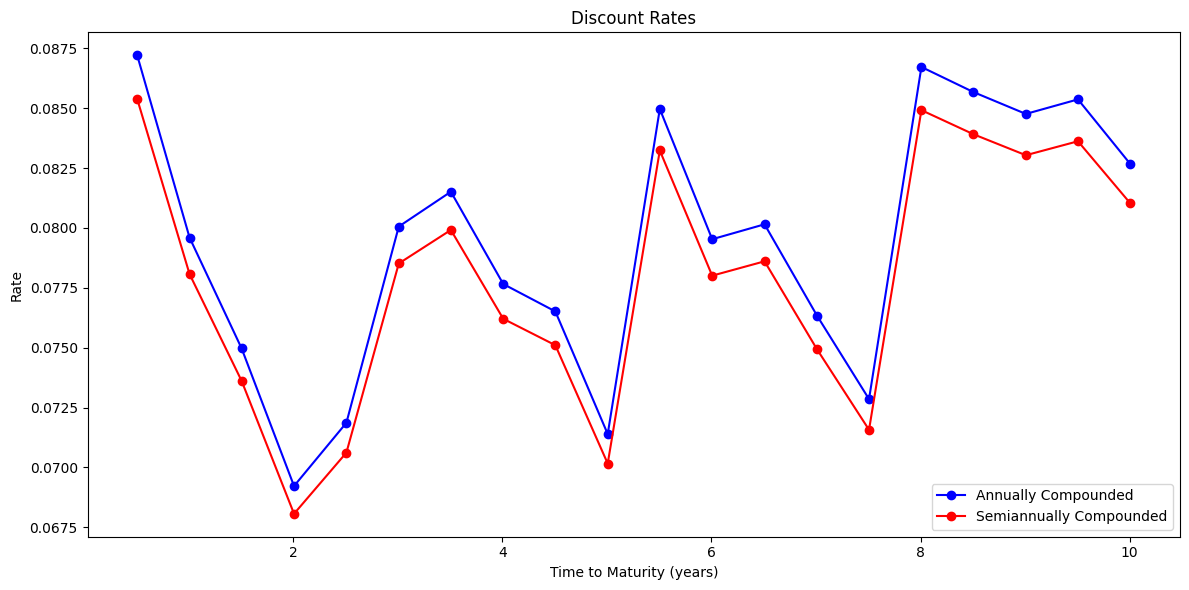

In [96]:
semiannual_cpd_rates = {}
annual_cpd_rates = {}

for date, df in spot_discount_factors.items():
    time_in_years = (date - quote_date).days / 365.25
    annual_cpd_rates[time_in_years] = (df ** (-1 / time_in_years)) - 1
    semiannual_cpd_rates[time_in_years] = ((1 + annual_cpd_rates[time_in_years]) ** 0.5 - 1) * 2

plt.figure(figsize=(12, 6))
plt.plot(annual_cpd_rates.keys(), annual_cpd_rates.values(), marker='o', linestyle='-', color='b')
plt.plot(semiannual_cpd_rates.keys(), semiannual_cpd_rates.values(), marker='o', linestyle='-', color='r')
plt.title("Discount Rates")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Rate")
plt.legend(['Annually Compounded', 'Semiannually Compounded'])
plt.tight_layout()
plt.show()

## 1.4

In [29]:
selected_quotes

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration
KYTREASNO,,,,,,,,,,,,,,,
208227,note,2025-11-28,2024-05-31,2026-05-31,0.503765,0.989071,4.875,100.521406,100.531220,100.526313,2.410861,102.937174,0.038263,7.142500e+10,0.492305
208316,note,2025-11-28,2024-11-30,2026-11-30,1.004791,0.989071,4.250,100.572266,100.591764,100.582015,2.101776,102.683791,0.036575,7.314900e+10,0.974601
208399,note,2025-11-28,2025-05-31,2027-05-31,1.503080,0.989071,3.875,100.453125,100.472656,100.462891,1.916325,102.379216,0.035621,7.844000e+10,1.448055
208484,note,2025-11-28,2025-11-30,2027-11-30,2.004107,0.000000,3.375,99.765625,99.769531,99.767578,0.000000,99.767578,0.034889,NaN,1.956136
208058,note,2025-11-28,2023-05-31,2028-05-31,2.505133,0.989071,3.625,100.312500,100.332031,100.322266,1.792691,102.114957,0.034901,4.936300e+10,2.376588
208145,note,2025-11-28,2023-11-30,2028-11-30,3.006160,0.989071,4.375,102.437500,102.472656,102.455078,2.163593,104.618671,0.035065,5.553400e+10,2.794544
208229,note,2025-11-28,2024-05-31,2029-05-31,3.504449,0.989071,4.500,103.171875,103.207031,103.189453,2.225410,105.414863,0.035258,7.415600e+10,3.218036
208318,note,2025-11-28,2024-11-30,2029-11-30,4.005476,0.989071,4.125,102.078125,102.132812,102.105469,2.039959,104.145428,0.035564,7.476100e+10,3.665596
208401,note,2025-11-28,2025-05-31,2030-05-31,4.503765,0.989071,4.000,101.730469,101.785156,101.757812,1.978142,103.735955,0.035754,7.958200e+10,4.092696


nelson-siegel parameters (beta_0, beta_1, beta_2, tau): [ 0.04188342  0.00331308 -0.02992069  0.99963516]


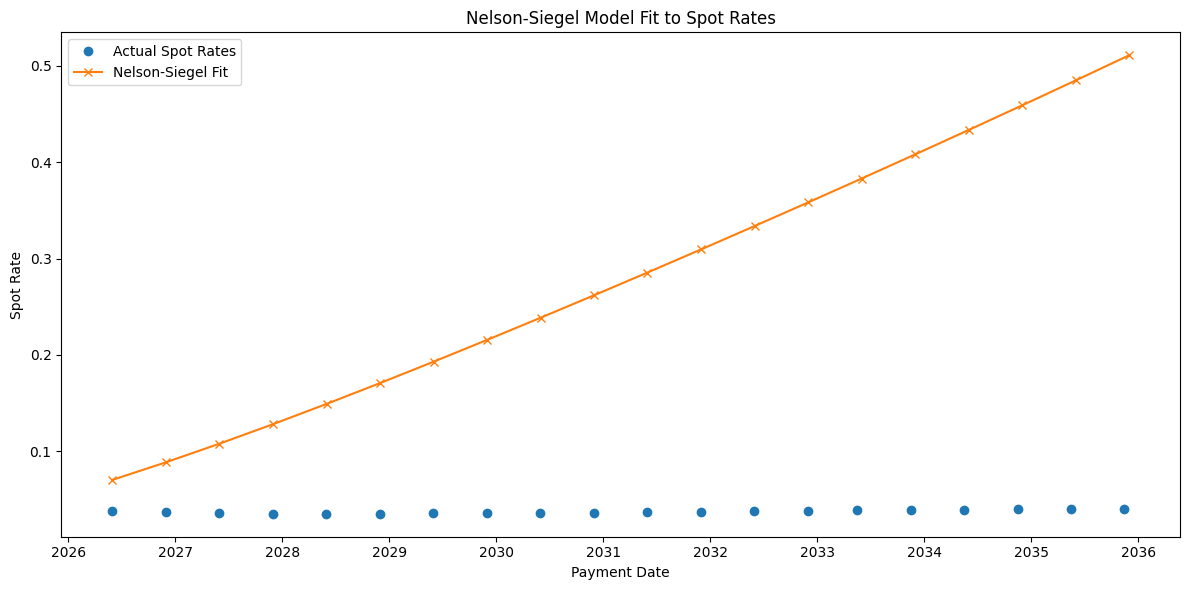

In [55]:
# NS notes from paper
# r(m): instantaneous forward rate at time me
#       eventually modeled as r(m) = beta_0 + beta_1 * exp(-m / tau) + beta_2 * (m / tau) * exp(-m / tau)
# YTM on bill: R(m) = 1/m ∫0^m r(x) dx
#       solved integral: R(m) = beta_0 + (beta_1 + beta_2) * (1 - exp(-m / tau)) / (m / tau) - beta_2 * exp(-m / tau)
# interpretation: long-term is beta_0, short-term is beta_1, mid-term is beta_2
# short-term decays as e^-m, medium term emerges and then decays as m e^-m

# NOTE: a little sketchy, need to check numbers and how it's fit

def nelson_siegel(beta_0, beta_1, beta_2, tau, m):
    # estimates ytm
    term1 = beta_0
    term2 = (beta_1 + beta_2) * (1 - np.exp(-m / tau)) / (m / tau)
    term3 = -beta_2 * np.exp(-m / tau)
    return term1 + term2 + term3

def nelson_siegel_mse(args):
    beta_0, beta_1, beta_2, tau = args
    ytms = selected_quotes['ytm']
    ms = selected_quotes['ttm']
    preds = [nelson_siegel(beta_0, beta_1, beta_2, tau, m) for m in ms]
    return np.mean((ytms - preds) ** 2)

ns_optimize = scipy.optimize.minimize(nelson_siegel_mse, x0=[-0.03, -0.02, 0.02, 1.0])
ns_params = ns_optimize.x

print("nelson-siegel parameters (beta_0, beta_1, beta_2, tau):", ns_params)

# plot of nelson-siegel fit vs actual spot rates
ms = np.array([(date - first_date).days / 365.25 for date in spot_discount_factors.keys()])
ns_ytms = [nelson_siegel(ns_params[0], ns_params[1], ns_params[2], ns_params[3], m) for m in ms]
# semi-annual compounded discount rates from NS model
ns_fitted_rates = [2 * ((1 / np.exp(-ytm * m)) ** (1/2) - 1) for ytm, m in zip(ns_ytms, ms)]

plt.figure(figsize=(12, 6))
# plt.plot(spot_discount_factors.keys(), [ -np.log(df) / m for df, m in zip(spot_discount_factors.values(), ms)], marker='o', linestyle='', label='Actual Spot Rates')
plt.plot(selected_quotes['maturity date'], selected_quotes['ytm'], marker='o', linestyle='', label='Actual Spot Rates')
plt.plot(spot_discount_factors.keys(), ns_fitted_rates, marker='x', linestyle='-', label='Nelson-Siegel Fit')
plt.title("Nelson-Siegel Model Fit to Spot Rates")
plt.xlabel("Payment Date")
plt.ylabel("Spot Rate")
plt.legend()
plt.tight_layout()
plt.show()

Nelson-Siegel parameters: beta0=0.085936, beta1=0.733495, beta2=-0.690881, tau=0.201


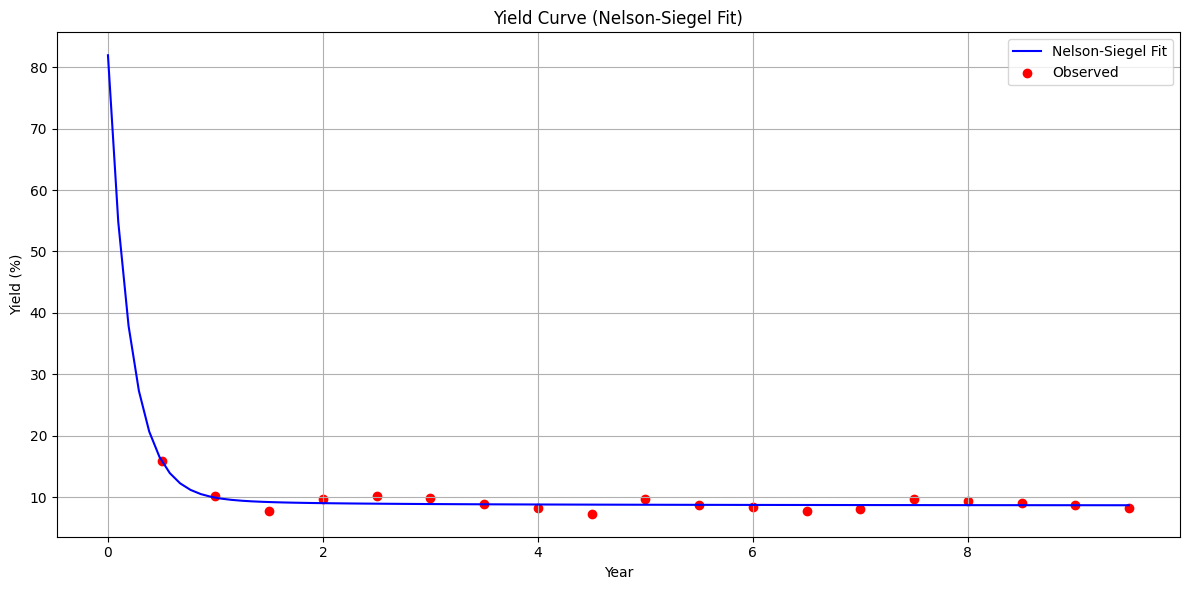

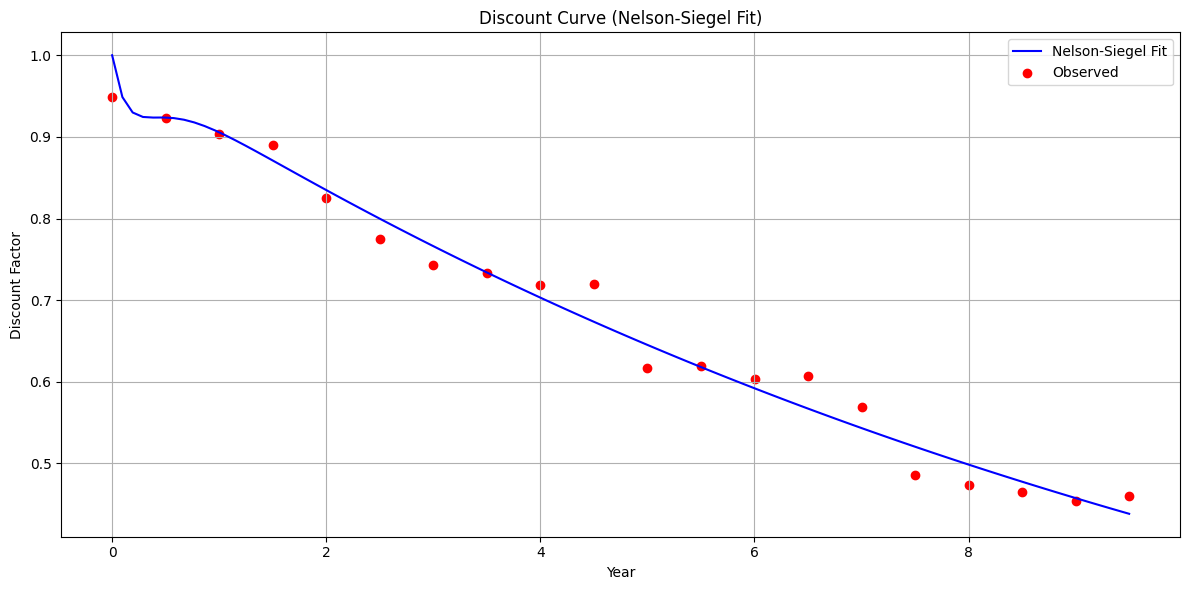

In [31]:
# Nelson-Siegel model for fitting the discount curve (straight from Cursor's generation)

import numpy as np
from scipy.optimize import curve_fit

# 1. Prepare data: convert payment dates to time in years from first date
ref_date = min(spot_discount_factors.keys())
date_list = np.array(list(spot_discount_factors.keys()))
t = np.array([(d - ref_date).days / 365.25 for d in date_list])
df_values = np.array(list(spot_discount_factors.values()))

# 2. Compute (continuously compounded) yield for each discount factor
def discount_to_yield(d, df):
    t = (d - ref_date).days / 365.25
    if t == 0 or df <= 0:
        return np.nan
    return -np.log(df) / t

yields = np.array([discount_to_yield(d, df) for d, df in zip(date_list, df_values)])

# Remove any NaNs (e.g., if t==0)
mask = ~np.isnan(yields)
t_fit = t[mask]
yields_fit = yields[mask]

# 3. Nelson-Siegel parametric form
def nelson_siegel(t, beta0, beta1, beta2, tau):
    with np.errstate(divide='ignore', invalid='ignore'):
        # Avoid division by zero for t~0: set shape to be same as t
        t = np.asarray(t)
        factor = np.where(t == 0, 1.0, (1 - np.exp(-t / tau)) / (t / tau))
    return beta0 + beta1 * factor + beta2 * (factor - np.exp(-t / tau))

# 4. Fit Nelson-Siegel model to the observed yields
p0 = [0.03, -0.03, 0.02, 2.0]  # initial guesses: beta0, beta1, beta2, tau
bounds = ([-1, -1, -1, 0.01], [1, 1, 1, 10])

params, _ = curve_fit(nelson_siegel, t_fit, yields_fit, p0=p0, bounds=bounds)
beta0, beta1, beta2, tau = params

print("Nelson-Siegel parameters: beta0={:.6f}, beta1={:.6f}, beta2={:.6f}, tau={:.3f}".format(beta0, beta1, beta2, tau))

# 5. Estimate yields and discount factors on a smooth grid
t_grid = np.linspace(0, max(t), 100)
ns_yields = nelson_siegel(t_grid, *params)
ns_discounts = np.exp(-ns_yields * t_grid)

# 6. Plot: Overlay the Nelson-Siegel fitted curve and observed points

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(t_grid, ns_yields*100, label='Nelson-Siegel Fit', color='blue')
plt.scatter(t_fit, yields_fit*100, color='red', label='Observed')
plt.title('Yield Curve (Nelson-Siegel Fit)')
plt.xlabel('Year')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_grid, ns_discounts, label='Nelson-Siegel Fit', color='blue')
plt.scatter(t, df_values, color='red', label='Observed')
plt.title('Discount Curve (Nelson-Siegel Fit)')
plt.xlabel('Year')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.1

In [101]:
# filtering out tips
quotes = quotes[~quotes['type'].str.contains('TIPS')]

In [102]:
quotes_payoff_dict = {}

for ix, row in quotes.iterrows():
    payoffs = {}
    curr_date = row['maturity date']
    while curr_date > row['issue date']:
        payoffs[curr_date] = row['cpn rate']
        curr_date -= pd.DateOffset(months=6)
    payoffs[row['maturity date']] = 100
    quotes_payoff_dict[ix] = payoffs
quotes_cashflow_matrix = pd.DataFrame(quotes_payoff_dict).sort_index().transpose().fillna(0)

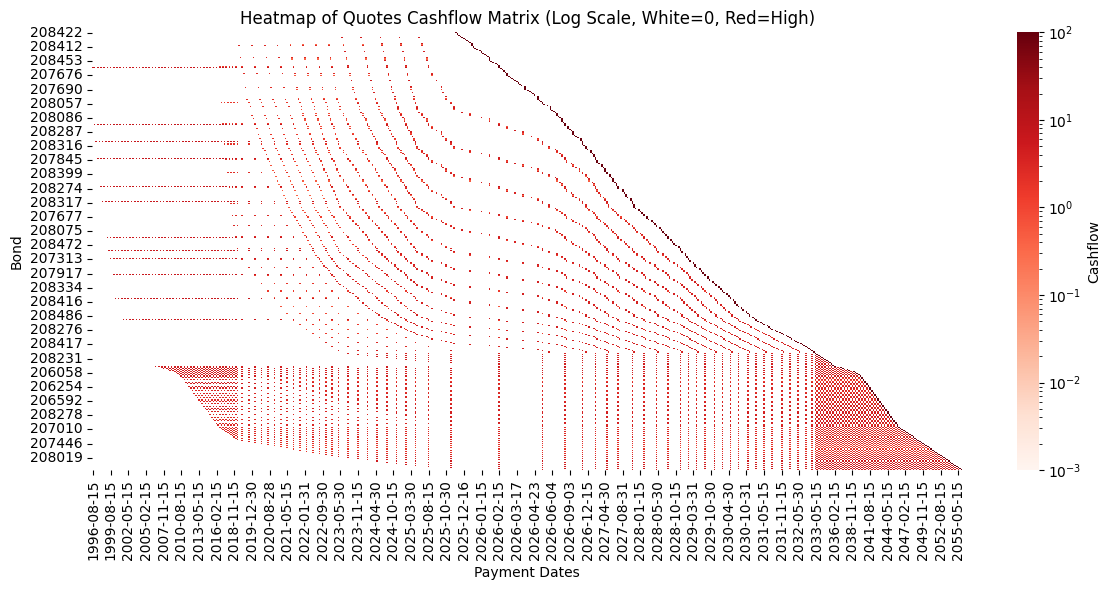

In [103]:
# display
quotes_cashflow_matrix.columns = quotes_cashflow_matrix.columns.date

plt.figure(figsize=(12, 6))
sns.heatmap(
    quotes_cashflow_matrix, 
    cmap="Reds",            # 0=white, high=red
    norm=plt.matplotlib.colors.LogNorm(vmin=1e-3, vmax=quotes_cashflow_matrix.values.max()),  # log scale, avoid log(0)
    cbar_kws={'label': 'Cashflow'}
)
plt.title("Heatmap of Quotes Cashflow Matrix (Log Scale, White=0, Red=High)")
plt.xlabel("Payment Dates")
plt.ylabel("Bond")
plt.tight_layout()
plt.show()

In [104]:
## display
print("head")
display(quotes_cashflow_matrix.head())

print("tail")
display(quotes_cashflow_matrix.tail())

print("most cashflow")
greatest_date = quotes_cashflow_matrix.sum(axis=0).idxmax()
print(greatest_date, quotes_cashflow_matrix.sum(axis=0)[greatest_date])

print("most issues")
col_with_most_nonzero = quotes_cashflow_matrix.astype(bool).sum(axis=0).idxmax()
print(col_with_most_nonzero, quotes_cashflow_matrix.astype(bool).sum(axis=0)[col_with_most_nonzero])

head


,1996-08-15,1997-02-15,1997-05-15,1997-08-15,1997-11-15,1998-02-15,1998-05-15,1998-08-15,1998-11-15,1999-02-15,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
208422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


tail


,1996-08-15,1997-02-15,1997-05-15,1997-08-15,1997-11-15,1998-02-15,1998-05-15,1998-08-15,1998-11-15,1999-02-15,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
208322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,4.500,0.000,4.500,0.000,100.000,0.00,0.000,0.0,0.0
208362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.625,0.000,4.625,0.000,4.625,0.000,100.00,0.000,0.0,0.0
208405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,4.750,0.000,4.750,0.000,4.750,0.00,100.000,0.0,0.0
208448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.750,0.000,4.750,0.000,4.750,0.000,4.75,0.000,100.0,0.0
208490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,4.625,0.000,4.625,0.000,4.625,0.00,4.625,0.0,100.0


most cashflow
2026-02-15 571.5
most issues
2026-02-15 82


## 2.2

In [105]:
maturity_dates = quotes['maturity date']
c_hat = quotes_cashflow_matrix[maturity_dates]

print("head")
display(c_hat.head())

print("tail")
display(c_hat.tail())

head


,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
208422,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


tail


,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
208322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,4.500,0.000,4.500,0.000,100.000,0.00,0.000,0.0,0.0
208362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.625,0.000,4.625,0.000,4.625,0.000,100.00,0.000,0.0,0.0
208405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,4.750,0.000,4.750,0.000,4.750,0.00,100.000,0.0,0.0
208448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.750,0.000,4.750,0.000,4.750,0.000,4.75,0.000,100.0,0.0
208490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,4.625,0.000,4.625,0.000,4.625,0.00,4.625,0.0,100.0


TTM vs discount rates

/var/folders/rz/3nbdc4dx58b3z8ykrycg25r80000gn/T/ipykernel_7180/2243532599.py:17: RuntimeWarning: invalid value encountered in scalar power
  quotes_semiannual_cpd_rates[ttm] = 2 * ((1 / quotes_discount_factors[date]) ** (1/2) - 1)


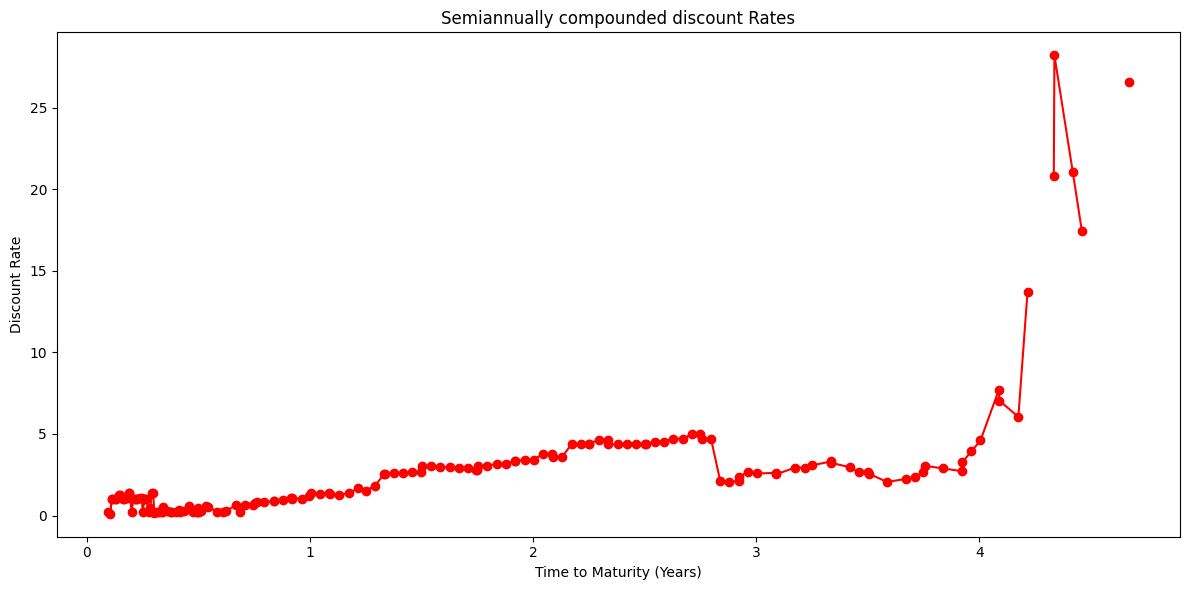

In [110]:
quotes_instrument_prices = quotes['price']
quotes_discount_regression = LR(fit_intercept=False)
quotes_discount_regression.fit(c_hat, quotes_instrument_prices)

describe_lr(quotes_discount_regression, c_hat, quotes_instrument_prices)

quotes_discount_factors = dict(zip(quotes_cashflow_matrix.columns, quotes_discount_regression.coef_))
quotes_discount_factors = {k: v for k, v in quotes_discount_factors.items() if k.year >= 2026}

first_date = min(quotes_discount_factors.keys()) - pd.DateOffset(months=6)
quotes_semiannual_cpd_rates = {}

# pulling quote date from above as it is the same

for date in quotes_discount_factors.keys():
    ttm = (date - quote_date).days / 365.25
    quotes_semiannual_cpd_rates[ttm] = 2 * ((1 / quotes_discount_factors[date]) ** (1/2) - 1)

plt.figure(figsize=(12, 6))
plt.plot(quotes_semiannual_cpd_rates.keys(), quotes_semiannual_cpd_rates.values(), marker='o', linestyle='-', color='r')
plt.title("Semiannually compounded discount Rates")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Discount Rate")
plt.tight_layout()
plt.show()

## 2.3

alpha (annualized)    0.185039
beta 0                0.142990
r squared             0.021246
dtype: float64


## 2.4

alpha        0.017747
beta 0       0.171210
beta 1      -2.187023
r squared    0.028545
dtype: float64


# Exercise: Forward Rates
## 1.1

In [112]:
selected_quotes

norm_selected_quotes = selected_quotes.copy()
# normalize issue date / maturity date to end of month
norm_selected_quotes['issue date'] = norm_selected_quotes['issue date'].apply(lambda d: d.replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1))
norm_selected_quotes['maturity date'] = norm_selected_quotes['maturity date'].apply(lambda d: d.replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1))

norm_selected_quotes

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration
KYTREASNO,,,,,,,,,,,,,,,
208227,note,2025-11-28,2024-05-31,2026-05-31,0.503765,0.989071,4.875,100.521406,100.531220,100.526313,2.410861,102.937174,0.038263,7.142500e+10,0.492305
208316,note,2025-11-28,2024-11-30,2026-11-30,1.004791,0.989071,4.250,100.572266,100.591764,100.582015,2.101776,102.683791,0.036575,7.314900e+10,0.974601
208399,note,2025-11-28,2025-05-31,2027-05-31,1.503080,0.989071,3.875,100.453125,100.472656,100.462891,1.916325,102.379216,0.035621,7.844000e+10,1.448055
208484,note,2025-11-28,2025-11-30,2027-11-30,2.004107,0.000000,3.375,99.765625,99.769531,99.767578,0.000000,99.767578,0.034889,NaN,1.956136
208058,note,2025-11-28,2023-05-31,2028-05-31,2.505133,0.989071,3.625,100.312500,100.332031,100.322266,1.792691,102.114957,0.034901,4.936300e+10,2.376588
208145,note,2025-11-28,2023-11-30,2028-11-30,3.006160,0.989071,4.375,102.437500,102.472656,102.455078,2.163593,104.618671,0.035065,5.553400e+10,2.794544
208229,note,2025-11-28,2024-05-31,2029-05-31,3.504449,0.989071,4.500,103.171875,103.207031,103.189453,2.225410,105.414863,0.035258,7.415600e+10,3.218036
208318,note,2025-11-28,2024-11-30,2029-11-30,4.005476,0.989071,4.125,102.078125,102.132812,102.105469,2.039959,104.145428,0.035564,7.476100e+10,3.665596
208401,note,2025-11-28,2025-05-31,2030-05-31,4.503765,0.989071,4.000,101.730469,101.785156,101.757812,1.978142,103.735955,0.035754,7.958200e+10,4.092696


In [ ]:


previous_roll_value = 100
previous_roll_date = quote_date_ts

for _, row in norm_selected_quotes.iterrows():
    curr_date = row['maturity date']

    redeem_value = 100 + row['cpn rate']

    roll_value = previous_roll_value * (1 + row['ytm'] * ( (curr_date - previous_roll_date).days / 365.25 ))
    print(f"Rolling from {previous_roll_date.date()} to {curr_date.date()}: previous value={previous_roll_value:.2f}, new value={roll_value:.2f}, ytm={row['ytm']:.4%}")
    previous_roll_value = roll_value
    previous_roll_date = curr_date

In [63]:
# bootstrapping
starting_date = min(selected_quotes['maturity date'])
spot_discount_factors

{datetime.date(2026, 6, 1): np.float64(0.9493127245679904),
 datetime.date(2026, 12, 1): np.float64(0.9237301153255264),
 datetime.date(2027, 6, 1): np.float64(0.9036117751696691),
 datetime.date(2027, 12, 1): np.float64(0.8903086399568848),
 datetime.date(2028, 6, 1): np.float64(0.8246475926825829),
 datetime.date(2028, 12, 1): np.float64(0.7745015790100466),
 datetime.date(2029, 6, 1): np.float64(0.7432729441683816),
 datetime.date(2029, 12, 1): np.float64(0.7326510684643603),
 datetime.date(2030, 6, 1): np.float64(0.7185426325680333),
 datetime.date(2030, 12, 1): np.float64(0.72022675468775),
 datetime.date(2031, 6, 1): np.float64(0.6162909516226593),
 datetime.date(2031, 12, 1): np.float64(0.6193376604114698),
 datetime.date(2032, 6, 1): np.float64(0.6029804184744504),
 datetime.date(2032, 12, 1): np.float64(0.6069902925420126),
 datetime.date(2033, 6, 1): np.float64(0.569288981346859),
 datetime.date(2033, 12, 1): np.float64(0.4854782558477265),
 datetime.date(2034, 6, 1): np.floa

# Exercise: The Carry Trade
## 1.1

In [ ]:
famabliss = pd.read_excel("./data/famabliss_strips_2025-11-28.xlsx", index_col=0, parse_dates=True)

# Set start_date to the Timestamp in famabliss's index matching November 2020
roll_month = 11
start_date = [date for date in famabliss.index if date.year == 2020 and date.month == roll_month][0]

size_value = 10**8
long_price = famabliss.loc[start_date, 5]
long_qty = size_value / long_price

# vanilla short sizing
vanilla_short_sizes = {}

for year in range(2020, 2025):
    short_date = [date for date in famabliss.index if date.year == year and date.month == roll_month][0]
    short_price = famabliss.loc[short_date, 1]
    short_qty = size_value / short_price
    
    vanilla_short_sizes[year] = short_qty

# calc yearly pnl
yearly_pnl = {}
for year in range(2021, 2025):
    current_date = [date for date in famabliss.index if date.year == year and date.month == roll_month][0]
    short_loss = vanilla_short_sizes[year - 1] - size_value
    long_price = famabliss.loc[current_date, 2025-year]
    # print(year, short_loss)
    long_gain = long_qty * long_price - size_value

    yearly_pnl[year] = long_gain - short_loss

# 2025 pnl
yearly_pnl[2025] = long_qty - vanilla_short_sizes[2024]

pnl_series = pd.Series(yearly_pnl)
# plt.plot(pnl_series.cumsum())

total_pnl = pnl_series.sum()

total_return = total_pnl / (4 * (10 ** 6))
print("total return:", total_return)


2021 116227.50751151145
2022 248347.30449268222
2023 4780616.141581476
2024 5143642.218233913
total return: -8.488364472016011


In [84]:
# quote_dates = [date for date in famabliss.index if date.year in range(2020, 2026) and date.month == roll_month]
# famabliss.loc[quote_dates]

## 1.2

In [89]:
# start_date = [date for date in famabliss.index if date.year == 2020 and date.month == roll_month][0]

# last_price = 1
# implied_rates = {}
# for year in range(1, 6):
#     current_price = famabliss.loc[start_date, year]
#     implied_rates[year] = last_price / current_price
#     last_price = current_price


# display(famabliss.loc[start_date])

# for k, v in implied_rates.items():
#     print(k, v)
# # print(implied_rates)

# # theoretical PnL under 2020 regime


In this case we should make no profit - because we roll the shorts from year to year, if the spot rates actually reflected the forward rates then the 5-year bond would be exactly the equivalent of the 1-year bond rolled from year to year. 

## 1.3

In [90]:
# rates in 2020 and 2025
quote_dates = [date for date in famabliss.index if date.year in [2020, 2025] and date.month == roll_month]
famabliss.loc[quote_dates]

,1,2,3,4,5
date,,,,,
2020-11-30,0.998839,0.997047,0.994464,0.988809,0.981515
2025-11-28,0.964936,0.932866,0.900919,0.868240,0.836057


In [92]:
print(famabliss.loc[quote_dates[0], 1] ** 5, famabliss.loc[quote_dates[0], 5])
print(famabliss.loc[quote_dates[1], 1] ** 5, famabliss.loc[quote_dates[1], 5])

0.9942088330487218 0.98151530715603
0.8365493921283316 0.8360573444246999


The trade looks less favorable for the period 2025-2030 compared to the period 2020-2025 because the difference in compounded discount rates is less, implying that the trade is less profitable. However, the real 5-year discount rate is greater in 2025 than in 2020, so if interest rates decrease in this period, the trade has more potential to become profitable. 